In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
def jump(mu0, sigma0, n0, mu1, sigma1, n1):
    
    X0 = np.random.normal(mu0, sigma0, n0).reshape(-1, 1)
    X1 = np.random.normal(mu1, sigma1, n1).reshape(-1, 1)
    
    X = np.concatenate((X0, X1), axis=0)
    T = np.arange(len(X))
    L = np.array([0]*n0 + [1]*n1)
    
    return T, X, L

In [5]:
mu0=0
sigma0=1
n0=200

mu1=1.
sigma1=1
n1=200

T, X, L = jump(mu0, sigma0, n0, mu1, sigma1, n1) 

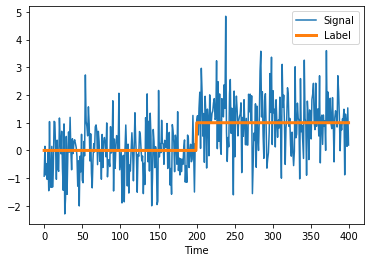

In [6]:
plt.plot(T, X, label='Signal')
plt.plot(T, L, label='Label', linewidth=3)
plt.xlabel('Time')
plt.legend()
plt.show() 

In [10]:
import torch

In [11]:
ss = StandardScaler()
X2 = ss.fit_transform(X)

In [16]:
from TIRE import DenseTIRE as TIRE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

window_size = 10
model = TIRE(input_dim=X.shape[1], window_size=window_size, 
             intermediate_dim_TD=0, intermediate_dim_FD=10, nfft=20).to(device)

model.fit(X2, epoches=100)

dissimilarities, change_point_scores = model.predict(X2)
scores = np.concatenate((np.zeros(window_size*2), dissimilarities[1:]))

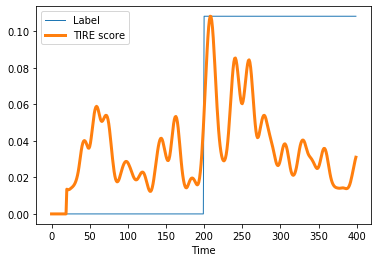

In [17]:
plt.plot(T, L*scores.max(), label='Label', linewidth=1)
plt.plot(T, scores, label='TIRE score', linewidth=3)
plt.xlabel('Time')
plt.legend()
plt.show()

In [20]:
from abc import ABCMeta, abstractmethod
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import sys
sys.path.append('../scripts')
import metrics

from joblib import Parallel, delayed


def run_experiments(algo_class, algo_params, thresholds, n_iters, mu_steps):
    curves_mean = []
    curves_std = []

    for mu1 in mu_steps:
        data_args = {
            "mu0": 0,
            "sigma0": 1,
            "n0": 300,
            "mu1": mu1,
            "sigma1": 1, 
            "n1": 100
        }
        
        args = (algo_class, algo_params, thresholds, data_args)
        curves = Parallel(n_jobs=-1)(delayed(run_and_estimate)(*args) for _ in range(n_iters))
        curve_mean = np.mean(curves, axis=0)
        curve_std = np.std(curves, axis=0) / np.sqrt(n_iters)

        curves_mean.append(curve_mean)
        curves_std.append(curve_std)
    
    return curves_mean, curves_mean    



def run_and_estimate(algo_class, algo_params, thresholds, data_args, cut=True):
    algorithm = algo_class(**algo_params)
    _, X, L = jump(**data_args)

    scores = algorithm.run(X)
    qm = metrics.OnlineQualityMetrics(thresholds)
    if cut:
        cut_size = algo_params["cut_size"]
        scores = scores[cut_size:]
        L = L[cut_size:]
    acurve = qm.estimate(scores, L) 
    return acurve

class CpdAlgo(metaclass=ABCMeta):
    @abstractmethod
    def run(self, X):
        pass
    
    def plot(self, T, L, scores):
        plt.plot(T, L * scores.max(), label='Label', linewidth=1)
        plt.plot(T, scores, label=self.label, linewidth=3)
        plt.xlabel('Time')
        plt.legend()

    
    def plot_curves(self, curves, mu_steps):
        plt.figure(figsize=(10, 7), dpi=100)
        colors = plt.cm.jet(np.linspace(0, 1, len(mu_steps)))

        for i, (mu1, acurve) in enumerate(zip(mu_steps, curves)):
            plt.plot(acurve[:, 1], acurve[:, 2], label=r"$\mu=$" + str(mu1), color=colors[i])
        plt.legend()
        plt.title(self.label)
        plt.xlabel('Time to False Alarm')
        plt.ylabel('Detection Delay')
        plt.show()
    
    def plot_std_box(self, curves_mean, curves_std, mu_steps, fta=100):
        dd100_mean = [mean[mean[:, 1] >= fta][0, 2] for mean in curves_mean]
        dd100_std  = [std[mean[:, 1] >= fta][0, 2] for (mean, std) in zip(curves_mean, curves_std)]
        
        plt.errorbar(mu_steps, dd100_mean, yerr=dd100_std, marker='o', fmt='o', 
             markeredgewidth=1, markersize=8, capsize=5, ls='', lw=2)

        plt.xlabel(r"$\frac{|\mu_1 - \mu_0|}{\sigma}$", size=20)
        plt.ylabel(r"Average Detection Delay", size=14)
        plt.title(r"Average Time to False Alarm >= 100")
        plt.grid(b=1)
        plt.show()
    
    def plots(self, curves_mean, curves_std, mu_steps):
        self.plot_curves(curves_mean, mu_steps)
        self.plot_std_box(curves_mean, curves_std, mu_steps)



class TireAlgo(CpdAlgo):
    def __init__(self, *args, **kwargs):
        self.window_size = kwargs["window_size"]
        self.intermediate_dim_TD = kwargs["intermediate_dim_TD"]
        self.intermediate_dim_FD = kwargs["intermediate_dim_FD"]
        self.nfft = kwargs["nfft"]
        self.epoches = kwargs["epoches"]
        self.device = kwargs["device"]
        self.label = kwargs["label"]
        
        self.cut_size = kwargs["cut_size"]
    
    def run(self, X):
        from TIRE import DenseTIRE as TIRE
        
        ss = StandardScaler()
        X2 = ss.fit_transform(X)
        device = torch.device(self.device)
        
        window_size = self.window_size
        model = TIRE(input_dim=X.shape[1], window_size=window_size,
                     intermediate_dim_TD=self.intermediate_dim_TD,
                     intermediate_dim_FD=self.intermediate_dim_FD,
                     nfft=self.nfft).to(device)
        
        model.fit(X2, epoches=self.epoches)
        
        dissimilarities, change_point_scores = model.predict(X2)
        scores = np.concatenate((np.zeros(window_size * 2), dissimilarities[1:]))
        
        return scores

In [19]:
mu_steps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.25, 1.5, 1.75, 2]

In [25]:
%%time

n_iters = 4
thresholds = np.linspace(0, 0.1, 1001)

tire_params = {
    "window_size": 50,
    "intermediate_dim_TD": 0, 
    "intermediate_dim_FD": 10, 
    "nfft": 20, 
    "epoches": 100,
    "device": "cpu", 
    "label": "TIRE score",
    "cut_size": 100
}

tire_mean, tire_std = run_experiments(TireAlgo, tire_params, thresholds, n_iters, mu_steps)

CPU times: user 762 ms, sys: 17 ms, total: 779 ms
Wall time: 1min 8s
